# HVSR Comparison: hvsr-lite vs hvsrpy

This notebook compares HVSR results from `hvsr-lite` and `hvsrpy` packages using the same seismic data and comparable parameters.


## 1. Setup and Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ObsPy for seismic data
from obspy import read, Stream
from obspy.core import UTCDateTime

# hvsr-lite imports
import sys
sys.path.append('..')
from hvsr_lite.core import compute_hvsr, HVSRResult
from hvsr_lite.utils import stream_to_dict

import hvsrpy

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 11

print("All imports successful!")


All imports successful!


## 2. Load Real MiniSEED Data


In [2]:
# Data directory
data_dir = Path('/Users/shihao/Research/CSM/Projects/BHP/BHP_OCELOT/SEISMIC/Data')

# Station
station_name = '453000225'
date_str = '2022.07.30.00.00.00.000'

east_file = data_dir / f"{station_name}..0.20.{date_str}.E_RESPREMOVED.miniseed"
north_file = data_dir / f"{station_name}..0.20.{date_str}.N_RESPREMOVED.miniseed"
vertical_file = data_dir / f"{station_name}..0.20.{date_str}.Z_RESPREMOVED.miniseed"

print(f"Loading data for station {station_name} on {date_str}")
print(f"Data directory: {data_dir}")

# Check if files exist
files_exist = all([east_file.exists(), north_file.exists(), vertical_file.exists()])

if not files_exist:
    print("Some files not found. Please check the data directory and file names.")


Loading data for station 453000225 on 2022.07.30.00.00.00.000
Data directory: /Users/shihao/Research/CSM/Projects/BHP/BHP_OCELOT/SEISMIC/Data


In [3]:
# Load the data
if files_exist:
    print("Loading MiniSEED data...")
    
    st_e = read(str(east_file))
    st_n = read(str(north_file))
    st_z = read(str(vertical_file))
    
    st_all = st_e + st_n + st_z
    
    print(f"Data loaded successfully")
    print(f"Components: {[tr.stats.channel for tr in st_all]}")
    print(f"Sampling rate: {st_all[0].stats.sampling_rate} Hz")
    print(f"Start time: {st_all[0].stats.starttime}")
    print(f"Duration: {st_all[0].stats.npts / st_all[0].stats.sampling_rate / 3600:.1f} hours")
    
else:
    print("Cannot proceed without data files")


Loading MiniSEED data...
Data loaded successfully
Components: ['HHE', 'HHN', 'HHZ']
Sampling rate: 250.0 Hz
Start time: 2022-07-30T00:00:00.000000Z
Duration: 24.0 hours


## 3. Data Preprocessing


In [4]:
# Preprocess data for HVSR analysis
if files_exist:
    print("Preprocessing data...")
    
    sampling_rate = st_all[0].stats.sampling_rate
    
    st_preprocessed = st_all.copy()
    st_preprocessed.detrend(type='demean')
    st_preprocessed.detrend(type='linear')
    st_preprocessed.taper(max_percentage=0.05, type='cosine')
    st_preprocessed.filter('bandpass', freqmin=0.1, freqmax=20.0, corners=4, zerophase=True)
    
    hvsr_data = stream_to_dict(st_preprocessed)
    
    print(f"Data preprocessed")
    print(f"Sampling rate: {hvsr_data['sampling_rate']} Hz")
    print(f"Duration: {len(hvsr_data['vertical']) / hvsr_data['sampling_rate'] / 3600:.1f} hours")
    print(f"Components: {list(hvsr_data.keys())}")
    
    horizontal_components = np.column_stack([hvsr_data['north'], hvsr_data['east']])
    vertical_data = hvsr_data['vertical']
    sampling_rate = hvsr_data['sampling_rate']
    
    north_data = hvsr_data['north']
    east_data = hvsr_data['east']
else:
    print("Cannot proceed without data files")

print("Preprocessing completed")


Preprocessing data...
Data preprocessed
Sampling rate: 250.0 Hz
Duration: 24.0 hours
Components: ['sampling_rate', 'east', 'north', 'vertical']
Preprocessing completed


## 4. HVSR Analysis with hvsr-lite


In [5]:
# HVSR analysis with hvsr-lite

if files_exist:
    print("HVSR Analysis with hvsr-lite...")
    
    overlap = 0.5
    smoothing_window = 5
    window_length = 40.0  # 40-second windows
    
    print(f"\nProcessing parameters:")
    print(f"Window length: {window_length} seconds")
    print(f"Overlap: {overlap*100:.0f}%")
    print(f"Sampling rate: {sampling_rate} Hz")
    
    # Test different smoothing methods

    smoothing_methods = [
        ('custom_ko', 'Custom KO'),
    ]
    # smoothing_methods = [
    #     ('custom_ko', 'Custom KO (default)'),
    #     ('custom_ko_smooth', 'Custom KO (high-smooth)'),
    #     ('moving_average', 'Moving Average'),
    #     ('konno_ohmachi', 'ObsPy KO')
    # ]
    
    hvsr_lite_results = {}
    
    for method, description in smoothing_methods:
        print(f"\n-- Using {description} --")
        
        try:
            result = compute_hvsr(
                horizontal_data=horizontal_components,
                vertical_data=vertical_data,
                sampling_rate=sampling_rate,
                window_length=window_length,
                overlap=overlap,
                smoothing_window=smoothing_window,
                stack_method='window_ratio_median',
                horizontal_combine='geometric_mean',
                smoothing_method=method,
                ko_bandwidth=40.0,
                sta_lta_ratio_threshold=2.0,
                max_amplitude_threshold=None,
                min_frequency=0.1,
                max_frequency=20.0,
                max_frequency_ratio=0.3,
                frequency_taper=False,  
                anti_aliasing_filter=True
            )
            
            hvsr_lite_results[method] = result
            
        except Exception as e:
            print(f"Failed: {e}")
            hvsr_lite_results[method] = None
    print(f"\nhvsr-lite analysis completed")
    print(f"Successful methods: {[k for k, v in hvsr_lite_results.items() if v is not None]}")
else:
    print("Cannot proceed without data files")


HVSR Analysis with hvsr-lite...

Processing parameters:
Window length: 40.0 seconds
Overlap: 50%
Sampling rate: 250.0 Hz

-- Using Custom KO --


Processing windows: 100%|██████████| 4319/4319 [00:13<00:00, 313.01win/s]


4263/4319 windows (98.7%)
Frequency: 0.12-19.5 Hz
Smoothing: Custom KO (bw=40.0)

hvsr-lite analysis completed
Successful methods: ['custom_ko']


## 5. HVSR Analysis with hvsrpy


In [6]:
# HVSR analysis with hvsrpy
if files_exist:
    print("HVSR Analysis with hvsrpy...")
    
    print(f"\nProcessing parameters:")
    print(f"  Window length: {window_length} seconds")
    print(f"  Frequency range: 0.1-20 Hz")
    print(f"  KO bandwidth: 40.0")
    print(f"  Method: geometric_mean")
    
    try:
        fnames = [[str(north_file), str(east_file), str(vertical_file)]]
        
        # Step 1: Read data
        srecords = hvsrpy.read(fnames)
        print(f"Data read: {len(srecords)} recording(s)")
        
        # Step 2: Configure preprocessing settings
        print(f"\nConfiguring preprocessing...")
        preprocessing_settings = hvsrpy.settings.HvsrPreProcessingSettings()
        preprocessing_settings.detrend = "linear"
        preprocessing_settings.window_length_in_seconds = window_length
        preprocessing_settings.orient_to_degrees_from_north = 0.0
        preprocessing_settings.filter_corner_frequencies_in_hz = (0.1, 20.0)  # Bandpass filter
        preprocessing_settings.ignore_dissimilar_time_step_warning = False
        
        print(f"Preprocessing settings:")
        print(f"Window length: {preprocessing_settings.window_length_in_seconds}s")
        print(f"Detrend: {preprocessing_settings.detrend}")
        print(f"Filter: {preprocessing_settings.filter_corner_frequencies_in_hz} Hz")
        
        # Apply preprocessing
        srecords = hvsrpy.preprocess(srecords, preprocessing_settings)
        print(f"Preprocessing completed")
        
        # Step 3: Configure processing settings
        print(f"\nConfiguring processing...")
        processing_settings = hvsrpy.settings.HvsrTraditionalProcessingSettings()
        processing_settings.window_type_and_width = ("tukey", 0.2)
        processing_settings.smoothing = dict(
            operator="konno_and_ohmachi",
            bandwidth=40.0,
            center_frequencies_in_hz=np.geomspace(0.1, 20, 200)
        )
        processing_settings.method_to_combine_horizontals = "geometric_mean"
        processing_settings.handle_dissimilar_time_steps_by = "frequency_domain_resampling"
        
        # Process data
        print(f"\nProcessing with hvsrpy...")
        hvsr_obj = hvsrpy.process(srecords, processing_settings)
        
        # Extract results
        if isinstance(hvsr_obj, list):
            hvsr_obj = hvsr_obj[0]
        
        # Get mean curve
        hvsrpy_freqs = hvsr_obj.frequency 
        hvsrpy_hvsr = hvsr_obj.mean_curve()   # Amplitudes
        
        # Get standard deviation
        try:
            std_curve = hvsr_obj.std_curve()
            hvsrpy_std = std_curve[1]  # Standard deviation
        except:
            hvsrpy_std = np.zeros_like(hvsrpy_hvsr)
        
        print(f"hvsrpy analysis completed")
        print(f"Frequencies: {len(hvsrpy_freqs)} points")
        print(f"Frequency range: {hvsrpy_freqs[0]:.3f} - {hvsrpy_freqs[-1]:.2f} Hz")
        print(f"HVSR range: {hvsrpy_hvsr.min():.3f} - {hvsrpy_hvsr.max():.2f}")
        
        # Calculate metrics
        high_freq_mask = hvsrpy_freqs > 5.0
        low_freq_mask = hvsrpy_freqs < 1.0
        
        # Store results
        hvsrpy_result = {
            'frequencies': hvsrpy_freqs,
            'hvsr_values': hvsrpy_hvsr,
            'hvsr_std': hvsrpy_std,
        }
        
    except Exception as e:
        import traceback
        print(f"hvsrpy analysis failed: {e}")
        print(f"Traceback: {traceback.format_exc()}")
        hvsrpy_result = None
        
else:
    print("Cannot proceed without data files")

print("Processing completed")


HVSR Analysis with hvsrpy...

Processing parameters:
  Window length: 40.0 seconds
  Frequency range: 0.1-20 Hz
  KO bandwidth: 40.0
  Method: geometric_mean
Data read: 1 recording(s)

Configuring preprocessing...
Preprocessing settings:
Window length: 40.0s
Detrend: linear
Filter: (0.1, 20.0) Hz
Preprocessing completed

Configuring processing...

Processing with hvsrpy...
hvsrpy analysis completed
Frequencies: 200 points
Frequency range: 0.100 - 20.00 Hz
HVSR range: 0.649 - 6.33
Processing completed


## 6. Comparison Visualization


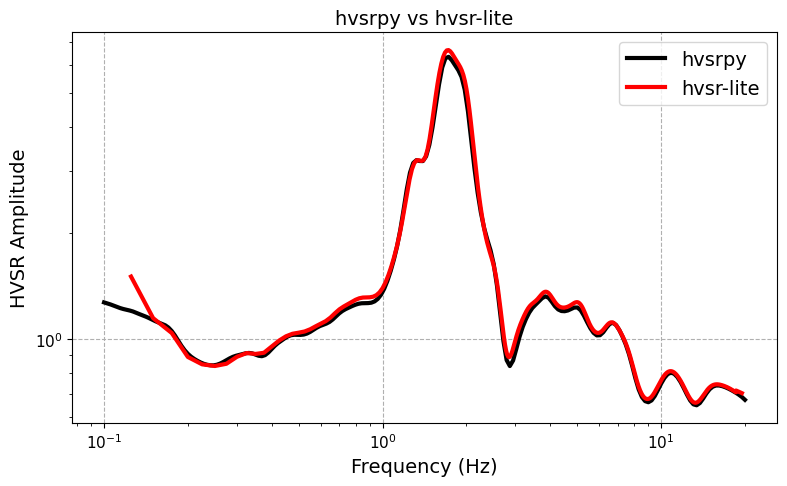

In [7]:
# Create comprehensive comparison plot
if files_exist and hvsrpy_result is not None:
    # Create figure with subplots
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    # Colors for different methods
    colors = {
        'custom_ko': 'red',
        'custom_ko_smooth': 'green',
        'moving_average': 'orange',
        'hvsrpy': 'black'
    }
    
    # hvsrpy
    ax.loglog(hvsrpy_result['frequencies'], hvsrpy_result['hvsr_values'], 
              color=colors['hvsrpy'], linewidth=3, label='hvsrpy')
    
    # hvsr-lite 
    if 'custom_ko' in hvsr_lite_results and hvsr_lite_results['custom_ko'] is not None:
        ax.loglog(hvsr_lite_results['custom_ko'].frequencies, hvsr_lite_results['custom_ko'].hvsr_values, 
                  color=colors['custom_ko'], linewidth=3, label='hvsr-lite')
    
    ax.set_xlabel('Frequency (Hz)',fontsize=14)
    ax.set_ylabel('HVSR Amplitude',fontsize=14)
    ax.set_title('hvsrpy vs hvsr-lite',fontsize=14)
    ax.grid(True, linestyle='--')
    ax.legend(fontsize=14)
    
    plt.tight_layout()
    plt.show()
